## Original code to test against Chris' Matlab scripts

```matlab
specvec = CV{jjj}(1110:1200,1).* range{jjj}(1238:1328,1)
```

In [1]:
from matplotlib.pyplot import figure, show, subplots_adjust, get_cmap
from echolab2.instruments import EK80
from echolab2.plotting.matplotlib import echogram
import numpy as np
from bs4 import BeautifulSoup as bs
from scipy.signal.windows import tukey
from scipy.fft import fft
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

def alphaFG(c, pH, T, D, S,f): # requires sound speed (m/s), pH, temp(C), depth(m), salinity(ppt), and nominal frequency(kHz)
    # Attenuation Coefficient is based on Francois and Garrison, 1982 - "Sound absorption based on ocean measurements.
    # Boric Acid Contribution, P1 = 1
    A1=((8.86/c)*(10**(0.78*pH-5)))
    f1=((2.8*((S/35)**0.5))*(10**(4-(1245/(T+273)))))
    # MgSO4 Contribution
    A2=((21.44*(S/c))*(1+(0.025*T)))
    P2=(1-(1.37*(10**-4)*D)+(6.2*(10**-9)*(D**2)))
    f2=((8.17*(10**(8-(1990/(T+273)))))/(1+.0018*(S-35)))
    # Pure water contribution, where A3 is temperature dependent
    if T > 20:
        A3=((3.964*(10**-4))-(1.146*(10**-5)*T)+(1.45*(10**-7)*(T**2))-(6.5*(10**-10)*(T**3)))
    else:
        A3=((4.937*(10**-4))-(2.59*(10**-5)*T)+(9.11*(10**-7)*(T**2))-(1.5*(10**-8)*(T**3)))
    P3=((1-(3.83*(10**-5)*D)) + (4.9*(10**-10)*(D**2)))
    # Calculate and return Alpha
    alpha = (((f**2)*A1*f1)/(((f1**2)) + (f**2)))+ ((A2*P2*f2*(f**2))/((f2**2) + (f**2))) + (A3*P3*(f**2))
    return alpha

def freqtransf(FFTvecin,fsdec,fc): #sampling decimation of band-limited signal
    nfft  = len(FFTvecin)
    FFTvec = np.ravel([FFTvecin, FFTvecin, FFTvecin])
    fvec  = fsdec*np.linspace(0,1-(1/nfft),nfft)
    fvec   = np.ravel([fvec,fsdec+fvec,(2*fsdec)+fvec])
    if fc > (fsdec/2):
        idxmin      = round((fc-fsdec/2)/fsdec*nfft)-1
    else:
        idxmin      = 1
    FFTvec = FFTvec[idxmin:idxmin+nfft]
    fvec = fvec[idxmin:idxmin+nfft]
    return FFTvec, fvec

In [233]:
nfft  = len(FFTvecin)
FFTvec = np.ravel([FFTvecin, FFTvecin, FFTvecin])
fvec  = fsdec*np.linspace(0,1-(1/nfft),nfft)
fvec   = np.ravel([fvec,fsdec+fvec,(2*fsdec)+fvec])
if fc > (fsdec/2):
    idxmin      = round((fc-fsdec/2)/fsdec*nfft)-1
else:
    idxmin      = 0
FFTvec = FFTvec[idxmin:idxmin+nfft]
fvec = fvec[idxmin:idxmin+nfft]

In [234]:
fvec[-1]

100952.14869237968

In [ ]:
nfft  = len(FFTvecin)
FFTvec  = FFTvec = np.ravel([FFTvecin, FFTvecin, FFTvecin])
fvec  = fsdec*np.linspace(0,1-(1/nfft),nfft)
fvec   = np.ravel([fvec,fsdec+fvec,(2*fsdec)+fvec])
if fc > (fsdec/2):
    idxmin      = round((fc-fsdec/2)/fsdec*nfft)
else:
    idxmin      = 1
FFTvec = FFTvec[idxmin:idxmin+nfft]
fvec = fvec[idxmin:idxmin+nfft]

In [1]:
rawfiles=['SME80/RWP_2018_deployment_plan-Phase0-D20190727-T081515-0-pp_55-90FM_split.raw']
calFilesXML=['SME80/SME80_FM.xml']
calFilesECS=['SME80/SME80_FM.ecs']

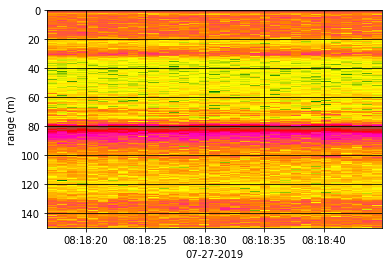

In [4]:
ek80 = EK80.EK80()
ek80.read_raw(rawfiles)
d = ek80.get_channel_data(frequencies=70000)
d = d[70000][0]
d.environment[0:-1] = d.environment[-1]

d_sv = d.get_Sv()
d_power = d.get_power()

fig_1 = figure()
eg = echogram.Echogram(fig_1, d_sv)
show()

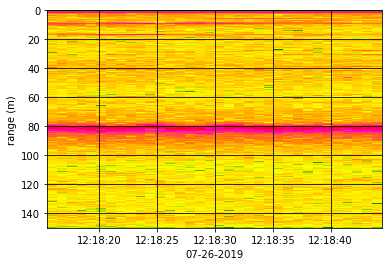

In [73]:
fig_1 = figure()
eg = echogram.Echogram(fig_1, d_power)
show()

In [352]:
class winSetup():
    def __init__(self,data):
        self.l = 1 # this is in pings, needs to be implemented such that we can look at multiple pings (mean across pings)
        step = 0.5 # this is in meters
        self.nfft = 2**9 # make this variable, take a window length across the channels, whats the max number of datapoints, thats the minimum fft for all channels
        deltaRange = data.range[1]-data.range[0]
        maxRange = data.range.max()
        maxRangeClipped = maxRange# - 75
        minRange = 0
        self.rangeBins = np.arange(minRange,maxRangeClipped+step,step)
        self.rangeBinCenters = self.rangeBins + step/2
        self.nInds = int(np.ceil(step/deltaRange))
        self.winInds = []
        for h in self.rangeBins:
            self.winInds.append(np.where(abs(data.range-h)==np.min(abs(data.range-h)))[0][0])


In [238]:
win = winSetup(d_power) # setup the window parameters

In [239]:
filename = 'FMProcessing/cv1.csv'
data = pd.read_csv(filename, sep=",", header=None)
data = np.ravel(data.applymap(lambda s: np.complex(''.join((s.replace('i', 'j')).split()))).values)

In [276]:
ping = 0 # ping number
i = 0 # window number
complexVoltage = np.mean(d.complex,axis=2) # get the complext voltage for each sample from the 4 channels
#cvWindow = complexVoltage[ping][win.winInds[i]:(win.winInds[i]+win.nInds)] # grab the complext voltages in the first window
cvWindow = data[1109:1200] # grab the complext voltages in the first window
#rWindow = d_power.range[win.winInds[i]:(win.winInds[i]+win.nInds)] # grab the ranges of that first window
rWindow = d_power.range[1109:1200] # grab the ranges of that first window
sVector = cvWindow*rWindow #scale the complex voltage by range to account for spreading 

In [277]:
#b = tukey(win.nInds,0.1)/(np.linalg.norm(tukey(win.nInds,0.1))/np.sqrt(win.nInds)) # build the tukey window with a 10% taper
b = tukey(91,0.1)/(np.linalg.norm(tukey(91,0.1))/np.sqrt(91)) # build the tukey window with a 10% taper
sVector = sVector*b # apply the tukey window
sVector = fft(sVector,win.nfft) # run the fft on the now windowed scaled volltages

In [278]:
FFTvecin = sVector
fsdec = 1/d.sample_interval[0] # sampling rate, parameter value in the config
fc = 70000 # nominal frequency, also a parameter factor, can be d_sv.frequency but currently there's a problem (talk to rick)

In [280]:
FFTvec_tmp, ftmp = freqtransf(FFTvecin,fsdec,fc) # this is a frequency transformation
# calculate alpha for each frequency in our spectra
alpha = [alphaFG(d.environment[0]['sound_speed'],d.environment[0]['acidity'],d.environment[0]['temperature'],d.environment[0]['depth'],d.environment[0]['salinity'],nomf/1000)/1000 for nomf in ftmp]

In [281]:
# This is how we get the data from the calibration xml documents
content = []
with open(calFilesXML[0], "r") as file:
    # Read each line in the file, readlines() returns a list of lines
    content = file.readlines()
    # Combine the lines in the list into a string
    content = "".join(content)
    bs_content = bs(content, "lxml")

calF = [float(f) for f in bs_content.find('calibrationresults').find('frequency').get_text().split(';')]
calG = [float(f) for f in bs_content.find('calibrationresults').find('gain').get_text().split(';')]
calPsi = float(bs_content.find('equivalentbeamangle').get_text())
calPsi = calPsi + 20*np.log10(70000/ftmp)

In [282]:
f = interp1d(calF, calG,fill_value=np.nan) # 1-d interpolation of the calibration gains so that they fit the size of our frequency vector
ftmp[ftmp< min(calF)] = np.nan
ftmp[ftmp> max(calF)] = np.nan
G = f(ftmp) # Gain interpolated to match the frequency values

In [283]:
dt = 2*(d_power.range[(win.winInds[i]+win.nInds)] - d_power.range[(win.winInds[i])])/d.environment[0]['sound_speed']
pr = np.abs(FFTvec_tmp)**2 # note sure I get what this is but I think it's the absolute value of the square of the complex data
zet = d.ZTRANSDUCER # transducer impedance
zer = d.ZTRANSCEIVER # transciever impedance
pTr = d.transmit_power[0] #Transmit power

In [284]:
svtmp = 10*np.log10(pr) +\
   [(2*float(win.rangeBinCenters[i]))*a for a in alpha] - 2*G - calPsi - \
   10*np.log10(dt) +\
   10*np.log10(4/zet/pTr/(2*np.sqrt(2))**2) +\
   10*np.log10((zer+zet)/zer) - \
   10*np.log10(d.environment[0]['sound_speed']**3/(32*np.pi**2*ftmp**2))

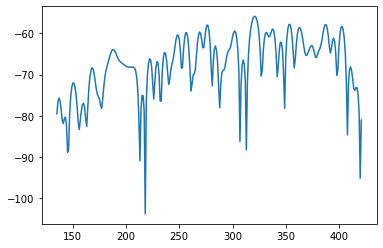

In [285]:
plt.plot(svtmp)

## Same process, but nor for checking agains the funtionalized version:

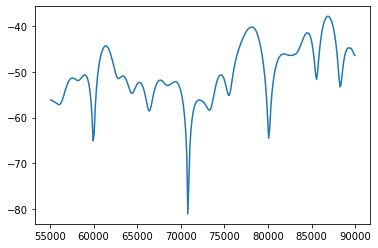

In [89]:
class winSetup():
    def __init__(self,data):
        self.l = 1 # this is in pings, needs to be implemented such that we can look at multiple pings (mean across pings)
        step = 0.5 # this is in meters
        self.nfft = 2**9 # make this variable, take a window length across the channels, whats the max number of datapoints, thats the minimum fft for all channels
        deltaRange = data.range[1]-data.range[0]
        maxRange = data.range.max()
        maxRangeClipped = maxRange - 75
        minRange = 0
        self.rangeBins = np.arange(minRange,maxRangeClipped+step,step)
        self.rangeBinCenters = self.rangeBins + step/2
        self.nInds = int(np.ceil(step/deltaRange))
        self.winInds = []
        for h in self.rangeBins:
            self.winInds.append(np.where(abs(data.range-h)==np.min(abs(data.range-h)))[0][0])

rawfiles=['SME80/RWP_2018_deployment_plan-Phase0-D20190727-T081515-0-pp_55-90FM_split.raw']
calFilesXML=['SME80/SME80_FM.xml']
calFilesECS=['SME80/SME80_FM.ecs']


ek80 = EK80.EK80()
ek80.read_raw(rawfiles)
d = ek80.get_channel_data(frequencies=70000)
d = d[70000][0]
d.environment[0:-1] = d.environment[-1]

d_sv = d.get_Sv()
d_power = d.get_power()

win= winSetup(d_power)

ping = 0 # ping number
i = 12 # window number
complexVoltage = np.mean(d.complex,axis=2) # get the complext voltage for each sample from the 4 channels
cvWindow = complexVoltage[ping][win.winInds[i]:(win.winInds[i]+win.nInds)] # grab the complext voltages in the first window
rWindow = d_power.range[win.winInds[i]:(win.winInds[i]+win.nInds)] # grab the ranges of that first window
sVector = cvWindow*rWindow #scale the complex voltage by range to account for spreading 

b = tukey(win.nInds,0.1)/(np.linalg.norm(tukey(win.nInds,0.1))/np.sqrt(win.nInds)) # build the tukey window with a 10% taper
sVector = sVector*b # apply the tukey window
sVector = fft(sVector,win.nfft) # run the fft on the now windowed scaled volltages

FFTvecin = sVector
fsdec = 1/d.sample_interval[0] # sampling rate, parameter value in the config
fc = 70000 # nominal frequency, also a parameter factor, can be d_sv.frequency but currently there's a problem (talk to rick)

FFTvec_tmp, ftmp = freqtransf(FFTvecin,fsdec,fc) # this is a frequency transformation
# calculate alpha for each frequency in our spectra
alpha = [alphaFG(d.environment[0]['sound_speed'],d.environment[0]['acidity'],d.environment[0]['temperature'],d.environment[0]['depth'],d.environment[0]['salinity'],nomf/1000)/1000 for nomf in ftmp]

# This is how we get the data from the calibration xml documents
content = []
with open(calFilesXML[0], "r") as file:
    # Read each line in the file, readlines() returns a list of lines
    content = file.readlines()
    # Combine the lines in the list into a string
    content = "".join(content)
    bs_content = bs(content, "lxml")

calF = [float(f) for f in bs_content.find('calibrationresults').find('frequency').get_text().split(';')]
calG = [float(f) for f in bs_content.find('calibrationresults').find('gain').get_text().split(';')]
calPsi = float(bs_content.find('equivalentbeamangle').get_text())
calPsi = calPsi + 20*np.log10(70000/ftmp)

f = interp1d(calF, calG,fill_value=np.nan) # 1-d interpolation of the calibration gains so that they fit the size of our frequency vector
ftmp[ftmp< min(calF)] = np.nan
ftmp[ftmp> max(calF)] = np.nan
G = f(ftmp) # Gain interpolated to match the frequency values

dt = 2*(d_power.range[(win.winInds[i]+win.nInds)] - d_power.range[(win.winInds[i])])/d.environment[0]['sound_speed']
pr = np.abs(FFTvec_tmp)**2 # note sure I get what this is but I think it's the absolute value of the square of the complex data
zet = d.ZTRANSDUCER # transducer impedance
zer = d.ZTRANSCEIVER # transciever impedance
pTr = d.transmit_power[0] #Transmit power
svtmp = 10*np.log10(pr) +\
   [(2*float(win.rangeBinCenters[i]))*a for a in alpha] - 2*G - calPsi - \
   10*np.log10(dt) +\
   10*np.log10(4/zet/pTr/(2*np.sqrt(2))**2) +\
   10*np.log10((zer+zet)/zer) - \
   10*np.log10(d.environment[0]['sound_speed']**3/(32*np.pi**2*ftmp**2))

plt.plot(ftmp,svtmp)

###  using only functions, window inputs, a calfile, and the ek80 object

In [215]:
import os
from matplotlib.pyplot import figure, show, subplots_adjust, get_cmap
from echolab2.instruments import EK80
from echolab2.plotting.matplotlib import echogram
import numpy as np
from bs4 import BeautifulSoup as bs
from scipy.signal.windows import tukey
from scipy.fft import fft
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt


class spectra():
    def __init__(self,windowX, windowZ, rawFiles, calFile, freqs=None):
        
        
        if windowX == 0:
            self.ek80 = EK80.EK80()
            print('Reading raw files...')
            self.ek80.read_raw(rawFiles[0])
            self.freqs = [freqs] if freqs is not None else list(ek80.frequency_map.keys())
            self.rawFiles = rawFiles
            self.windowX = 10**10 #make it something absurd
        else:
            self.ek80 = EK80.EK80()
            print('Reading raw files...')
            self.ek80.read_raw(rawFiles)
            self.freqs = [freqs] if freqs is not None else list(ek80.frequency_map.keys())
            self.windowX = int(windowX)
        self.windowZ = windowZ
        self.calFile = calFile
        self.spectraDict = {}
        
    def calcSpectra(self):
        print('calculating spectra for frequencies: ', self.freqs)
        for self.freq in self.freqs:
            self.spectraDict[self.freq] = {}
            self.data = self.ek80.get_channel_data(frequencies=self.freq)[self.freq][0]
            self.setWindow()
            
            self.spectraDict[self.freq]['rangeBinCenters'] = self.rangeBinCenters
            self.spectraDict[self.freq]['rangeBinSize'] = self.windowZ
            self.spectraDict[self.freq]['windowSampleIndex'] = self.winIndsZ
            self.spectraDict[self.freq]['windowPingStart'] = []
            self.spectraDict[self.freq]['Sv'] = []
            
            self.setCal()
            # calculate alpha for each frequency in our spectra 
            print('Calculating spectra for',len(self.winIndsZ), 'vertical windows in', len(self.nwinX),' horizontal windows')
            
            if self.windowX ==10**10:
                npings=0
                for file in self.rawFiles:
                    self.ek80.read_raw(file)
                    self.data = self.ek80.get_channel_data(frequencies=self.freq)[self.freq][0]
                    print(self.data.n_pings)
                    winSpec = []
                    for i in range(len(self.winIndsZ)):
                        ftmp, svtmp = self.specMath(self.winIndsZ[i],0,self.rangeBinCenters[i])
                        winSpec.append(svtmp)
                    self.spectraDict[self.freq]['Sv'].append(winSpec)
                    self.spectraDict[self.freq]['windowPingStart'].append(npings)
                    npings = npings+self.data.n_pings
            else:
                for winIndX in self.nwinX:
                    winSpec = []
                    for i in range(len(self.winIndsZ)):
                        ftmp, svtmp = self.specMath(self.winIndsZ[i],winIndX,self.rangeBinCenters[i])
                        winSpec.append(svtmp)
                    self.spectraDict[self.freq]['Sv'].append(winSpec)
                    self.spectraDict[self.freq]['windowPingStart'].append(self.windowX*winIndX)
            
            self.spectraDict[self.freq]['frequency'] = ftmp
            

    def setWindow(self):
        self.range = self.data.get_power().range # we need to do this since range isn't carried in the 'raw'
        if self.windowX == 10**10:
            self.nwinX = [0]
        else:
            self.nwinX = np.arange(int(np.ceil(self.data.n_pings/self.windowX)))
        step = self.windowZ # this is in meters
        self.nfft = 2**9 # make this variable, take a window length across the channels, whats the max number of datapoints, thats the minimum fft for all channels
        deltaRange = self.range[1]-self.range[0]
        maxRange = self.range.max()
        maxRangeClipped = maxRange-75 # these shouldn't be hardcoded but it's just for clipping
        minRange = 3 # these shouldn't be hardcoded but it's just for clipping
        self.rangeBins = np.arange(minRange,maxRangeClipped+step,step)
        self.rangeBinCenters = self.rangeBins + step/2
        self.nIndsZ = int(np.ceil(step/deltaRange))
        self.winIndsZ = []
        for h in self.rangeBins:
            self.winIndsZ.append(np.where(abs(self.range-h)==np.min(abs(self.range-h)))[0][0])
        
    def setCal(self):
        # Currently the read_ecs in echolab doesn't work so I'm going to do it myself from the xml. I'm not going to spend time on this since
        # when working, echolab will have the cal values stored for each channel already
        name, extension = os.path.splitext(self.calFile)
        print('Grabbing cal data from ',extension, 'file')
        if extension == '.xml':
            content = []
            with open(self.calFile, "r") as file:
                # Read each line in the file, readlines() returns a list of lines
                content = file.readlines()
                # Combine the lines in the list into a string
                content = "".join(content)
                bs_content = bs(content, "lxml")

            self.calF = [float(f) for f in bs_content.find('calibrationresults').find('frequency').get_text().split(';')]
            self.calG = [float(f) for f in bs_content.find('calibrationresults').find('gain').get_text().split(';')]
            self.calPsi = float(bs_content.find('equivalentbeamangle').get_text())
            
        # ECS can go here, but see comments above. 
            
            
    def specMath(self,winIndZ,winIndX,rangeBinCenter):
        complexVoltage = np.mean(self.data.complex,axis=2) # get the complext voltage for each sample from the 4 channels
        #curComplex = 
        cvWindow = (np.mean(complexVoltage[self.windowX*(winIndX):self.windowX*(winIndX+1)],axis=0))[winIndZ:(winIndZ+self.nIndsZ)] # grab the complext voltages in the first window
        self.range = self.data.get_power().range
        rWindow = self.data.get_power().range[winIndZ:(winIndZ+self.nIndsZ)] # grab the ranges of that first window
        sVector = cvWindow*rWindow #scale the complex voltage by range to account for spreading 
        b = tukey(self.nIndsZ,0.1)/(np.linalg.norm(tukey(self.nIndsZ,0.1))/np.sqrt(self.nIndsZ)) # build the tukey window with a 10% taper
        sVector = sVector*b # apply the tukey window
        sVector = fft(sVector,self.nfft) # run the fft on the now windowed scaled volltages
        FFTvecin = sVector
        fsdec = 1/self.data.sample_interval[0] # sampling rate, parameter value in the config
        FFTvec_tmp, ftmp = self.freqtransf(FFTvecin,fsdec,self.freq) # this is a frequency transformation   
        env = self.data.environment[self.data.environment != np.array(None)][0]
        self.alpha = [self.alphaFG(env['sound_speed'],env['acidity'],env['temperature'],env['depth'],env['salinity'],nomf/1000)/1000 for nomf in ftmp]
        
        f = interp1d(self.calF, self.calG,fill_value=np.nan) # 1-d interpolation of the calibration gains so that they fit the size of our frequency vector
        ftmp[ftmp< min(self.calF)] = np.nan
        ftmp[ftmp> max(self.calF)] = np.nan
        calPsi = self.calPsi + 20*np.log10(self.freq/ftmp)
        G = f(ftmp) # Gain interpolated to match the frequency values
        dt = 2*(self.range[(win.winInds[i]+win.nInds)] - self.range[(win.winInds[i])])/env['sound_speed']
        
        pr = np.abs(FFTvec_tmp)**2 # note sure I get what this is but I think it's the absolute value of the square of the complex data
        zet = self.data.ZTRANSDUCER # transducer impedance
        zer = self.data.ZTRANSCEIVER # transciever impedance
        pTr = self.data.transmit_power[0] #Transmit power

        svtmp = 10*np.log10(pr) +\
           [(2*rangeBinCenter*a) for a in self.alpha] - 2*G - calPsi - \
           10*np.log10(dt) +\
           10*np.log10(4/zet/pTr/(2*np.sqrt(2))**2) +\
           10*np.log10((zer+zet)/zer) - \
           10*np.log10(env['sound_speed']**3/(32*np.pi**2*ftmp**2))
        return ftmp, svtmp
      
        
    def alphaFG(self,c, pH, T, D, S,f): # requires sound speed (m/s), pH, temp(C), depth(m), salinity(ppt), and nominal frequency(kHz)
        # Attenuation Coefficient is based on Francois and Garrison, 1982 - "Sound absorption based on ocean measurements.
        # Boric Acid Contribution, P1 = 1
        A1=((8.86/c)*(10**(0.78*pH-5)))
        f1=((2.8*((S/35)**0.5))*(10**(4-(1245/(T+273)))))
        # MgSO4 Contribution
        A2=((21.44*(S/c))*(1+(0.025*T)))
        P2=(1-(1.37*(10**-4)*D)+(6.2*(10**-9)*(D**2)))
        f2=((8.17*(10**(8-(1990/(T+273)))))/(1+.0018*(S-35)))
        # Pure water contribution, where A3 is temperature dependent
        if T > 20:
            A3=((3.964*(10**-4))-(1.146*(10**-5)*T)+(1.45*(10**-7)*(T**2))-(6.5*(10**-10)*(T**3)))
        else:
            A3=((4.937*(10**-4))-(2.59*(10**-5)*T)+(9.11*(10**-7)*(T**2))-(1.5*(10**-8)*(T**3)))
        P3=((1-(3.83*(10**-5)*D)) + (4.9*(10**-10)*(D**2)))
        # Calculate and return Alpha
        alpha = (((f**2)*A1*f1)/(((f1**2)) + (f**2)))+ ((A2*P2*f2*(f**2))/((f2**2) + (f**2))) + (A3*P3*(f**2))
        return alpha

    def freqtransf(self,FFTvecin,fsdec,fc): #sampling decimation of band-limited signal
        nfft  = len(FFTvecin)
        FFTvec  = FFTvec = np.ravel([FFTvecin, FFTvecin, FFTvecin])
        fvec  = fsdec*np.linspace(0,1-(1/nfft),nfft)
        fvec   = np.ravel([fvec,fsdec+fvec,(2*fsdec)+fvec])
        if fc > (fsdec/2):
            idxmin      = round((fc-fsdec/2)/fsdec*nfft)-1
        else:
            idxmin      = 0
        FFTvec = FFTvec[idxmin:idxmin+nfft]
        fvec = fvec[idxmin:idxmin+nfft]
        return FFTvec, fvec

In [216]:
from glob import glob
files = glob('D:/SME80/RWP*FM_split.raw')
rawFiles = files[0:10]
#rawFiles=['SME80/RWP_2018_deployment_plan-Phase0-D20190727-T081515-0-pp_55-90FM_split.raw'] This is my test file for comparison
calFileXML='D:/SME80/SME80_FM.xml'

s = spectra(0, 5, rawFiles, calFileXML)
s.calcSpectra()

Reading raw files...
calculating spectra for frequencies:  [70000.0]
Grabbing cal data from  .xml file
Calculating spectra for 16 vertical windows in 1  horizontal windows
22
28
34
29
29
29
33
33
29
29


Text(0.5, 1.0, '23.0 to 28.0m range')

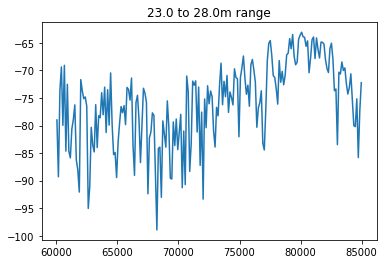

In [235]:
windowX = 1
windowZ = 4
fFilt = tuple([(s.spectraDict[70000]['frequency'] >=60000)&(s.spectraDict[70000]['frequency'] <=85000)])
windowHeight = s.spectraDict[70000]['rangeBinCenters'][1]-s.spectraDict[70000]['rangeBinCenters'][0]
windowBot = s.spectraDict[70000]['rangeBinCenters'][windowZ]-windowHeight/2
windowTop = windowBot+windowHeight 
plt.plot(s.spectraDict[70000]['frequency'][fFilt],s.spectraDict[70000]['Sv'][windowX][windowZ][fFilt])
plt.title(str(windowBot)+' to '+str(windowTop)+'m range')